#Newness Detection using Feature Vectors
Name: **Amr OKASHA** 

ID: **2476539**

This notebook presents the code written for ME536 semester project more fluidly by showing the implementation step-by-step while also including all outputs of code blocks for better analysis.

A lot of presented content here was inspired by [this notebook](https://colab.research.google.com/drive/1qZ-v10zPs73AkVTgo7s84JAZT1tLFrVW?authuser=1)

The code presented is altered to process a prerecorded video since google colab prevents capturing directly from a webcam. The full code can be found on my [github](https://github.com/amrokasha76/ME536_Project.git). In that code, the same process outlined here analyzes frames from a livefeed in real time. 

#Start with imports

In [ ]:
#Import necessary libraries
import numpy as np
import cv2
import tensorflow as tf
#Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
#For PCA
from scipy.spatial import distance
from sklearn import decomposition
#Replaying cv2.imshow
from google.colab.patches import cv2_imshow

In [ ]:
def colorConvert(image):
  '''
  Returns the RGB image of of the passed BGR image
  '''
  return(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

#Load feature extractor
The CNN used to extract features is EfficientNet B0.

In [ ]:
#inputs = tf.keras.layers.Input([50, 50, 3], dtype=tf.uint8)
net = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', pooling='avg')

16711680/16705208 [==============================] - 0s 0us/step


#Load pre-recorded video

The video will be loaded directly from my drive. The video can also be loaded manually

In [ ]:
#change to True if video is to be loaded manually
manual = False

if manual:
  path = '/content'
  vid_name = 'Video_cap_2.mp4' #Please provide name here
  cap = cv2.VideoCapture(f'{path}/{vid_name}')
  print('Video Loaded')
  img_name = 'Video_cap_2_Moment.jpg' #Please provide name of sample image here
  print('Image Loaded')
else:
  cap = cv2.VideoCapture('/content/drive/MyDrive/ME536/Video_cap_2.mp4')
  print('Video Loaded')
  sample_frame = cv2.imread("/content/drive/MyDrive/ME536/Video_cap_2_Moment.jpg")
  print("Image Loaded")


Video Loaded
Image Loaded


##Extract first 15 frames which contain only backgorund
This step makes background substraction in later processing easier and more effective. The downside in application is that the camera must be held steady for a couple of seconds to capture a clear shot of background

Background captured


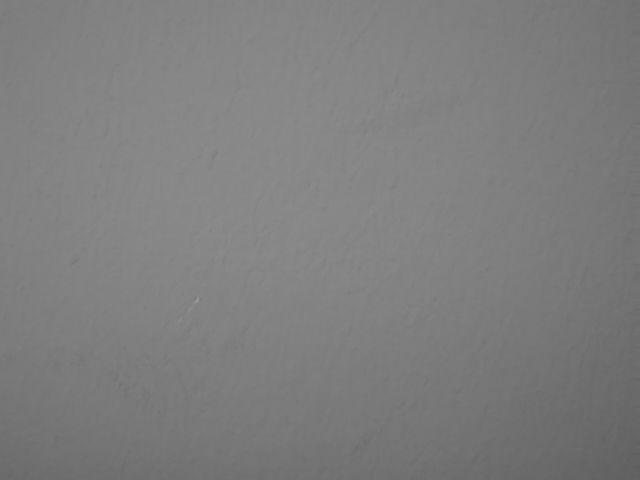

In [ ]:
frames = []
for count in range(15):
    success, frame = cap.read()
    frames.append(frame)
bg = np.average(frames, axis=0).astype(dtype=np.uint8)
bg_gray = cv2.cvtColor(bg, cv2.COLOR_BGR2GRAY)
print("Background captured")
cv2_imshow(bg_gray)

#Sample Frame Processing
Let's grab a single frame and demonstrate how each image processing algorithm affects that frame

##Get a sample frame from capture
The obtained frame contains an object that should be detected by the algorithm and identified with a new index if its new, or propery label it if it isn't.

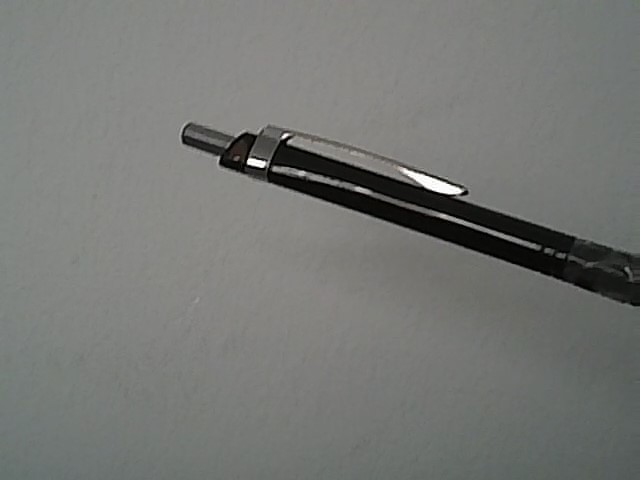

In [ ]:
cv2_imshow(sample_frame)

##Get grayscale image
Grayscale images simplify dealing with images as they reduce their dimension.

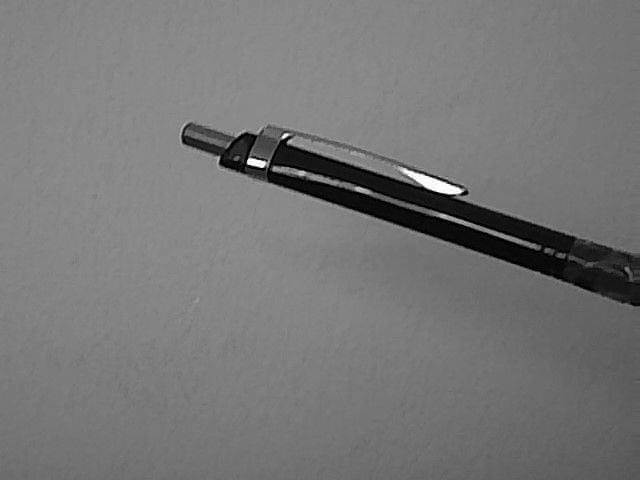

In [ ]:
gray_sample_frame = cv2.cvtColor(sample_frame, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_sample_frame)

##Remove background by substracting it from current frame

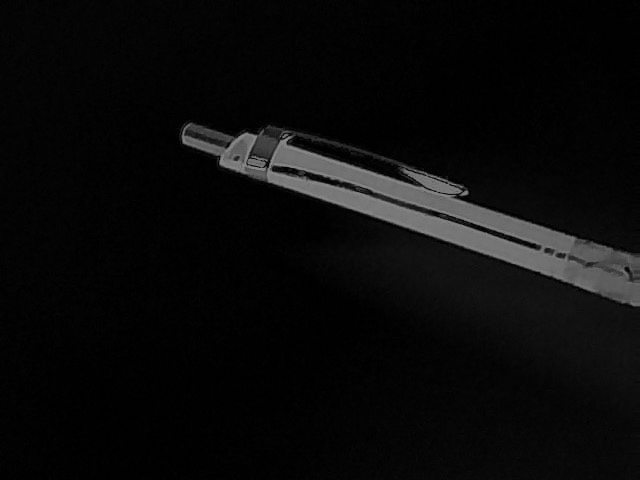

In [ ]:
bg_rem_sample = cv2.absdiff(gray_sample_frame, bg_gray)
cv2_imshow(bg_rem_sample)

##Apply a Gaussian 11x11-kernel blur
The blur helps mitigate the effects of noise

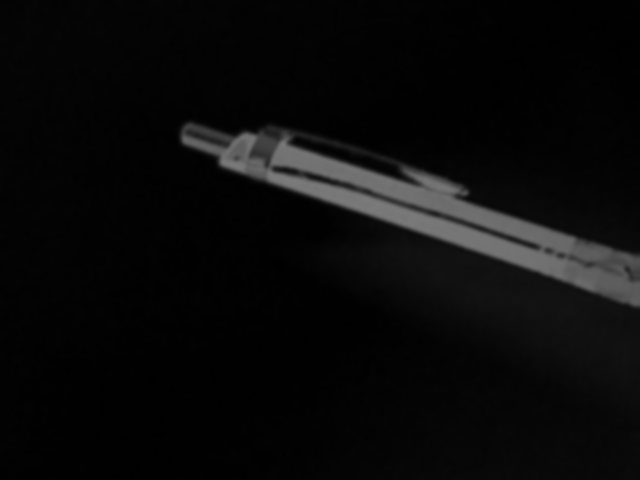

In [ ]:
blur_sample = cv2.GaussianBlur(bg_rem_sample, (11,11), 0)
cv2_imshow(blur_sample)

##Apply threshold to get binary image
Thresholding is used to obtain a binary image. Here a combination of OpenCV's OTSU and Binary thresholds are used. 

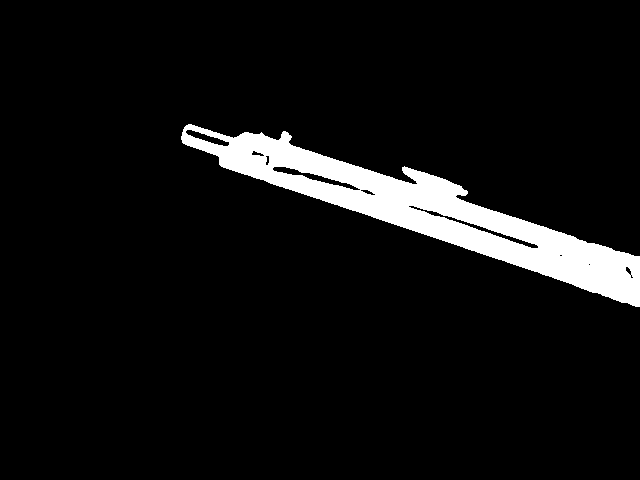

In [ ]:
rete, sample_threshold = cv2.threshold(blur_sample, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
cv2_imshow(sample_threshold)

##Dilate to remove noise
Dilating the image with a 5x5 filter helps close up the most of the remaning holes

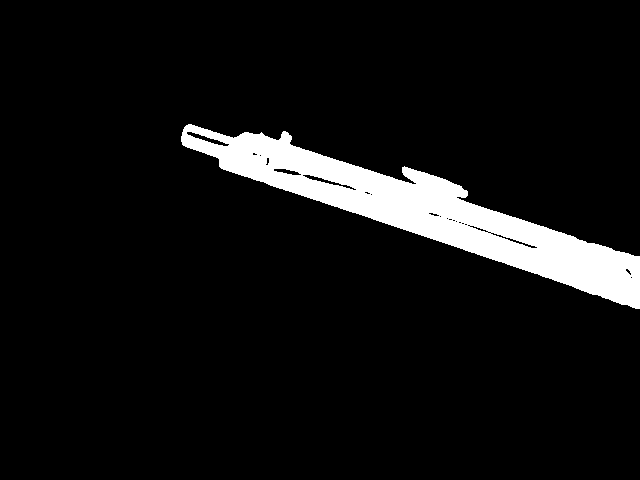

In [ ]:
sample_threshold_dl = cv2.dilate(sample_threshold, (5, 5), iterations=2)
cv2_imshow(sample_threshold_dl)

##Find contours
Finding the contours is the crux of this algorithm and is the reason why so many image preprocessing was done. Finding good and clean contours will help greatly in detecting and classifying objects

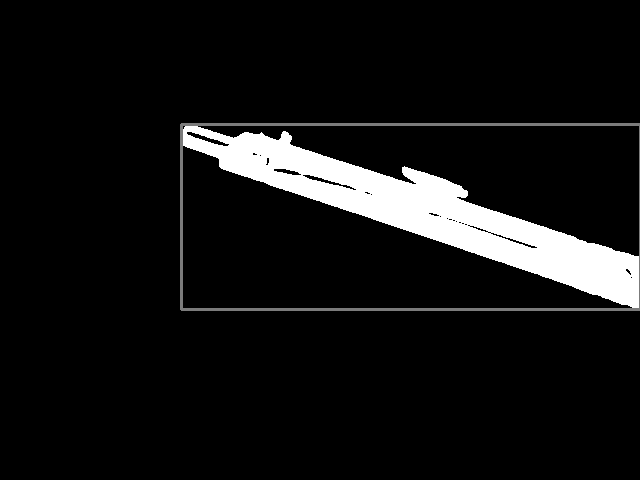

In [ ]:
#Finds contours in image
(cons, _) = cv2.findContours(sample_threshold_dl.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for c in cons: #loops through all discovered contours
  x, y, width, height = cv2.boundingRect(c) #finds bounding box's dimensions 
  cv2.rectangle(sample_threshold_dl, (x, y), (x + width, y + height), (123, 0, 255), 2) #draws bbox
  cv2_imshow(sample_threshold_dl)

##Extract features
Once the contours are located, cropouts from the original image can be extracted and passed through the neural network to finally obtain the feature vectors belonging to this particular frame

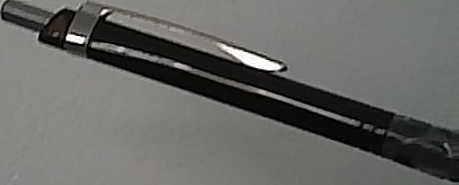

The feature vector has shape: (1, 1280)


In [ ]:
crop = sample_frame[y:(y + height), x:(x + width)]  #takes a crop from orignal image with size of bbox
cv2_imshow(crop)
#passes crop through CNN
emb = net(crop)
emb = emb.numpy()
print(f'The feature vector has shape: {emb.shape}')

#Main Loop
In this section, the provided video will be processed as described in the report and will return the same video annotated with the discovered objects. The loop also returns a list of labelled features for further analysis. 

##Video writer
Initializes a video writer to recompile the video with modified frames

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_writer = cv2.VideoWriter('Detect.avi', fourcc, 20.0, (640, 480))

##Run main loop

In [ ]:
#Define some variables
kernel = np.array((5, 5)) #filter for dilation 
#Blur thresholds to mitigate the effects of motion on object detection
minBlur = 350
maxBlur = 3000
#Frame count for loop
tot_frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
#Define cosine similarity threshold
cosThresh = 0.7

#Initialize some lists
obj_emb_mem = []
for_PCA = []
labels = []

#Begin loop
for frm in range(int(tot_frame_count-1)):
  #read frame from video and apply previously outlines series of image processing
  success, frame = cap.read()
  gray_frame_sample = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

  bg_removed_frame = cv2.absdiff(gray_frame_sample, bg_gray)

  frame_blur = cv2.GaussianBlur(bg_removed_frame, (11, 11), 0)

  ret, frame_threshold = cv2.threshold(frame_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  frame_threshold = cv2.dilate(frame_threshold, kernel, iterations=2)

  blur = cv2.Laplacian(frame_threshold, cv2.CV_64F).var()

  (contours, _) = cv2.findContours(frame_threshold.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  #Run the contour classiication loop
  for i in contours:
    area = cv2.contourArea(i) 
    #filter by area
    if area > 4000 and blur > minBlur and blur < maxBlur:

      #Get bounding box
      x, y, width, height = cv2.boundingRect(i)
      cv2.rectangle(frame, (x, y), (x + width, y + height), (123, 0, 255), 2)

      # Get features
      temp_crop = frame[y:(y + height), x:(x + width)]
      
      #pass cropout through CNN
      embeds = net(temp_crop)
      embeds = embeds.numpy()
      
      #save feature for subsequent PCA analysis
      for_PCA.append(embeds)

      #If first object, do not run comparisons
      if len(obj_emb_mem) == 0:
          obj_emb_mem.append(embeds)
          labels.append(0)
      #Else, look at other objects detected and compute the similarity cosine distance 
      else:
          temp_dist = []
          #get all cosine similarities in frame
          for idx, obj in enumerate(obj_emb_mem):
              temp_dist.append(distance.cosine(obj, embeds))

          dis = min(temp_dist)  #define the minimum
          if dis > cosThresh:   #if the minimum is larger than the threshold, object must be new
              cv2.putText(frame,'NOT SAME OBJECT',(x, y+15),1,1,(255,0,0),1)
              obj_emb_mem.append(embeds)
              print(f'New obj count: {len(obj_emb_mem)}')
          else:   #else, 
              dis_min_idx = temp_dist.index(dis)
              cv2.putText(frame, 'SAME OBJECT ID ' + str(dis_min_idx), (x, y+15), 1, 1, (255, 0, 0), 1)
          #save label for subsequent PCA analysis
          labels.append(temp_dist.index(dis))
  #add frame to video
  video_writer.write(cv2.resize(frame, (640,480)))

# Releasing Video Object
cap.release()
video_writer.release()

New obj count: 2
New obj count: 3
New obj count: 4
New obj count: 5
New obj count: 6
New obj count: 7
New obj count: 8
New obj count: 9
New obj count: 10


error: ignored

#Principal Component Analysis
This section tries to validate the results of the previous algorithm using PCA. 

In [ ]:
#Get a numpy array of feature vectors
np_obj_arr = np.reshape(np.array([obj for obj in for_PCA]), (len(for_PCA),1280))
np_obj_arr.shape

(797, 1280)

##2D Feature Space

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


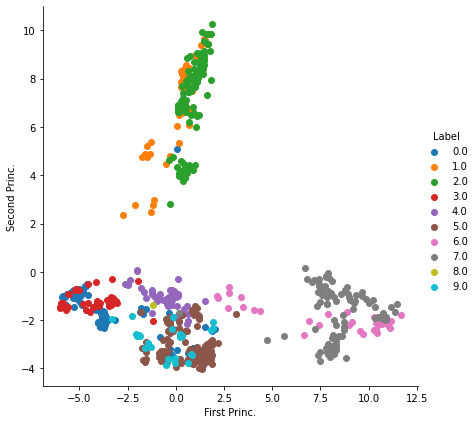

In [ ]:
#define pca decomposition
pca = decomposition.PCA()
pca.n_components = 2
#find the first two principal components of the data for plotting
pca_data = pca.fit_transform(np_obj_arr)
#add labels for plotting
pca_data = np.vstack((pca_data.T, labels)).T
#get a data farme
pca_df = pd.DataFrame(data=pca_data, columns=("First Princ.", "Second Princ.", "Label"))
#plot data
sn.FacetGrid(pca_df, hue="Label", height=6).map(plt.scatter,"First Princ.", "Second Princ.").add_legend()
plt.show()